## Summary

* One of the issues I noticed with the previous regression model when I was testing on QPO frequencies was although it could predict Frequencies for true QPOs well, the network was very bad at predicting 0 as the frequency for "qpos" that don't exist, i.e. it would predict 0.6 for the frequency of a third qpo when that pds only had two qpos. See this plot: 

![](https://raw.githubusercontent.com/personal-research/MAXI-J1535/main/archive/images/frequency_regression.png "Initial Frequency Regression")

* My proposed solution is this: combine the classification model I designed in ```interim.ipynb``` with the regression model I designed in ```exploring_regression_architectures.ipynb```. Since the classification model could predict (with ~85% accuracy) the number of QPOs, what if I make the model predict the number of QPOs first, and then automatically return 0s for outputs of the "buffer" qpos. For example, if the model predicts that there is only one qpo, it will only run regression for one frequency and return the frequency array ```[freq, 0, 0]``` rather than attempting to fit something weird for those second two frequencies when they should be zero. 

## Notes on Models for Combined Classification and Regression

* [machine learning mastery article](https://machinelearningmastery.com/neural-network-models-for-combined-classification-and-regression/)

```python
# split into input (X) and output (y) variables
X, y = dataset[:, 1:-1], dataset[:, -1]
X, y = X.astype('float'), y.astype('float')
n_features = X.shape[1]
# encode strings to integer
y_class = LabelEncoder().fit_transform(y)
n_class = len(unique(y_class))
# split data into train and test sets
X_train, X_test, y_train, y_test, y_train_class, y_test_class = train_test_split(X, y, y_class, test_size=0.33, random_state=1)
# input
visible = Input(shape=(n_features,))
hidden1 = Dense(20, activation='relu', kernel_initializer='he_normal')(visible)
hidden2 = Dense(10, activation='relu', kernel_initializer='he_normal')(hidden1)
# regression output
out_reg = Dense(1, activation='linear')(hidden2)
# classification output
out_clas = Dense(n_class, activation='softmax')(hidden2)
# define model
model = Model(inputs=visible, outputs=[out_reg, out_clas])
# compile the keras model
model.compile(loss=['mse','sparse_categorical_crossentropy'], optimizer='adam')
```

![](https://machinelearningmastery.com/wp-content/uploads/2021/02/Plot-of-the-Multi-Output-Model-for-Combine-Regression-and-Classification-Predictions.jpg "Network Flowchart")

## Model Merging in Keras
* [stack exchange article](https://datascience.stackexchange.com/questions/26103/merging-two-different-models-in-keras)

![](https://i.stack.imgur.com/2xIdb.png "Network Flowchart")


```python
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model
A1 = Input(shape=(30,),name='A1')
A2 = Dense(8, activation='relu',name='A2')(A1)
A3 = Dense(30, activation='relu',name='A3')(A2)

B2 = Dense(40, activation='relu',name='B2')(A2)
B3 = Dense(30, activation='relu',name='B3')(B2)

merged = Model(inputs=[A1],outputs=[A3,B3])
```

## Update
* I think I'll either use a custom layer or custom activation function. Currently pursuing the latter. 

## Code

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
from keras import models, layers
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.layers import Input, Dense
from keras.models import Model

np.set_printoptions(suppress=True)
data_df = pd.read_csv('https://github.com/personal-research/MAXI-J1535/raw/main/data/processed/full.csv')

ImportError: ignored

In [ ]:
data_df = data_df.sample(frac=1) # shuffle the dataframe

def normalize(x):
    x = (x-min(x))/(max(x)-min(x))
    return x

# X

arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities) = (normalize(np.array(data_df[arr_name])) for arr_name in arr_names)

## Stack x values
x_vals = np.array([], dtype=np.int64).reshape(0,6) # why are they type int

for a, b, c, d, e, f in zip(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f)])
    x_vals = np.vstack([x_vals, new_arr])

# Y 
y_vals = np.array([], dtype=np.float32).reshape(0, 3)

freq1s, freq2s, freq3s = (normalize(np.array(data_df[arr_name])) for arr_name in ['first_par1s', 'second_par1s', 'third_par1s'])

for freq1, freq2, freq3 in zip(freq1s, freq2s, freq3s): 
    new_arr = np.array([float(freq1), float(freq2), float(freq3)])
    y_vals = np.vstack([y_vals, new_arr])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=0.2)

In [ ]:
import numpy as np

In [ ]:
# custom function
#from keras import backend as K
def cullBuffers(x, qpo_classes): # qpo_classes needs to be determined before hand
    new_x = np.array([], dtype=np.float64).reshape(0,3)
    for x_row, qpo_class in zip(x, qpo_classes): 
        if qpo_class == 0: 
            new_x = np.vstack([new_x, np.zeros(3)])

        elif qpo_class == 1:
            new_x = np.vstack([new_x, [x_row[0], 0, 0]])

        elif qpo_class == 2: 
            new_x = np.vstack([new_x, [x_row[0], x_row[1], 0]])

        elif qpo_class == 3: 
            new_x = np.vstack([new_x, x_row[0:3]])

    return new_x

In [ ]:
print(cullBuffers([[1., 1., 1.], [2., 2., 2.], [3., 3., 3.], [4., 4., 4.,]], [0, 1, 2, 3]))

[[0. 0. 0.]
 [2. 0. 0.]
 [3. 3. 0.]
 [4. 4. 4.]]


# Two Separate Models Model

## Notes
* Create another correlation matrix? 
* Move towards combined model with custom layer or activation function?
* Should probably read about ensemble models 
* Look into parameter distributions like red chi lol 
* So I should also make that plot with histograms and x:y scatter plots

### Plan for this model

1.   Implement the double model (make sure that train test doesn't leak)     
2.   Iterate through lots of configurations of the component models to optimize them for this model







In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
from keras import models, layers
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.layers import Input, Dense
from keras.models import Model

np.set_printoptions(suppress=True)

combined_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/fixed_merged.csv')

In [11]:
combined_df = combined_df.sample(frac=1) # shuffle the dataframe

def normalize(x):
    x = (x-min(x))/(max(x)-min(x))
    return x

# X

arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities) = (normalize(np.array(combined_df[arr_name])) for arr_name in arr_names)

## Stack x values
x_vals = np.array([], dtype=np.int64).reshape(0,6) # why are they type int

for a, b, c, d, e, f in zip(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f)])
    x_vals = np.vstack([x_vals, new_arr])

# num QPOS
num_qpos = np.array(combined_df['num_qpos']).reshape(len(combined_df), 1).astype(int)

# Y 
y_vals = np.array([], dtype=np.float32).reshape(0, 3)

freq1s, freq2s, freq3s = (normalize(np.array(combined_df[arr_name])) for arr_name in ['first_par1s', 'second_par1s', 'third_par1s'])

for freq1, freq2, freq3 in zip(freq1s, freq2s, freq3s): 
    new_arr = np.array([float(freq1), float(freq2), float(freq3)])
    y_vals = np.vstack([y_vals, new_arr])

# Train test split
X_train, X_test, y_train, y_test, qpo_train, qpo_test = train_test_split(x_vals, y_vals, num_qpos, test_size=0.1)

In [3]:
def class_model():
    model = models.Sequential()
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='relu')) 
    model.add(layers.Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def regress_model(): 
    model = models.Sequential()
    model.add(layers.Dense(10, activation='relu')) 
    model.add(layers.Dense(10, activation='relu')) 
    model.add(layers.Dense(3, activation='linear'))
    opt = tf.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse', metrics='mae')

    return model

def train_combined_model(x_train, y_train, qpo_train, class_epochs, reg_epochs, val_split, batch_size): 
    classModel = class_model()
    class_history = classModel.fit(X_train, qpo_train, validation_split = val_split, epochs=class_epochs, batch_size=batch_size, verbose=0) # val = 0.1, batch size =25 
    regressModel = regress_model()
    regress_history = regressModel.fit(X_train, y_train, validation_split = val_split, epochs=reg_epochs, batch_size=batch_size, verbose=0)

    return classModel, class_history, regressModel, regress_history

def combined_predict(classModel, regressModel, x_test): 
    def cullBuffers(x, qpo_classes):
        new_x = np.array([], dtype=np.float64).reshape(0,3)
        for x_row, qpo_class in zip(x, qpo_classes): 
            if qpo_class == 0: 
                new_x = np.vstack([new_x, np.zeros(3)])

            elif qpo_class == 1:
                new_x = np.vstack([new_x, [x_row[0], 0, 0]])

            elif qpo_class == 2: 
                new_x = np.vstack([new_x, [x_row[0], x_row[1], 0]])

            elif qpo_class == 3: 
                new_x = np.vstack([new_x, x_row[0:3]])

        return new_x
    
    class_predictions = classModel.predict(x_test) # is this the right shape?

    regress_predictions = regressModel.predict(x_test)

    return cullBuffers(regress_predictions, class_predictions)


def combined_v2(x_train, y_train, qpo_train, class_epochs, reg_epochs, val_split, batch_size, x_test):
    classModel = class_model()
    class_history = classModel.fit(X_train, qpo_train, validation_split = val_split, epochs=class_epochs, batch_size=batch_size, verbose=0) # val = 0.1, batch size =25 
    regressModel = regress_model()
    regress_history = regressModel.fit(X_train, y_train, validation_split = val_split, epochs=reg_epochs, batch_size=batch_size, verbose=0)

    print('training complete')

    def cullBuffers(x, qpo_classes):
        new_x = np.array([], dtype=np.float64).reshape(0,3)
        for x_row, qpo_class in zip(x, qpo_classes): 
            if qpo_class == 0: 
                new_x = np.vstack([new_x, np.zeros(3)])

            elif qpo_class == 1:
                new_x = np.vstack([new_x, [x_row[0], 0, 0]])

            elif qpo_class == 2: 
                new_x = np.vstack([new_x, [x_row[0], x_row[1], 0]])

            elif qpo_class == 3: 
                new_x = np.vstack([new_x, x_row[0:3]])

        return new_x
    
    softmax_probs = classModel.predict(x_test)
    
    class_predictions = np.array([]) # wrong shape?

    class_options = np.array([0, 1, 2, 3])
    for row in softmax_probs: 
        qpo_class = class_options[np.argmax(row)]
        class_predictions = np.append(class_predictions, qpo_class)

    print(class_predictions)
    
    regress_predictions = regressModel.predict(x_test)

    return cullBuffers(regress_predictions, class_predictions), class_history, regress_history


In [8]:
class_epochs = 800
reg_epochs = 1500
predictions, class_hist, reg_hist = combined_v2(X_train, y_train, qpo_train, class_epochs, reg_epochs, 0.1, 25, X_test)

training complete
[0. 0. 0. 2. 2. 0. 0. 0. 2. 0. 0. 0. 0. 0. 2. 2. 0. 0. 0.]


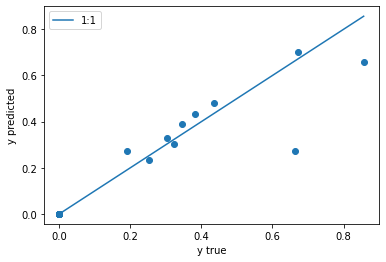

In [10]:
flat_y_test = y_test.flatten()
flat_y_pred = predictions.flatten()

x_line = np.linspace(min(flat_y_test), max(flat_y_test), 3)

plt.scatter(flat_y_test, flat_y_pred)
plt.plot(x_line, x_line, label='1:1')
plt.xlabel('y true')
plt.ylabel('y predicted')
plt.legend()

plt.show()

In [20]:
print(len(predictions))

19
